## The Project

The goals / steps of this project are the following:


* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.


Here are links to the labeled data for vehicle and non-vehicle examples to train your classifier. These example images come from a combination of the GTI vehicle image database, the KITTI vision benchmark suite, and examples extracted from the project video itself. You are welcome and encouraged to take advantage of the recently released Udacity labeled dataset to augment your training data.

Some example images for testing your pipeline on single frames are located in the test_images folder. To help the reviewer examine your work, please save examples of the output from each stage of your pipeline in the folder called ouput_images, and include them in your writeup for the project by describing what each image shows. The video called project_video.mp4 is the video your pipeline should work well on.

As an optional challenge Once you have a working pipeline for vehicle detection, add in your lane-finding algorithm from the last project to do simultaneous lane-finding and vehicle detection!

If you're feeling ambitious (also totally optional though), don't stop there! We encourage you to go out and take video of your own, and show us how you would implement this project on a new video!

# Imports...

In [1]:
import glob, pickle, cv2, glob, pickle, os
import numpy as np
import tracker
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip

# scale images depending on extension/image type
def read_image(image_path):
    return mpimg.imread(image_path)


# *PerspectiveTransform* Class

The __*PerspectiveTransform*__ class as derived from the __*Advance Lane Lines*__ project...

In [2]:
class PerspectiveTransform:
    def __init__(self, SRC, DST):

        self.ret = None
        self.mtx = None
        self.dist = None
        self.rvecs = None
        self.tvecs= None
        
        self.get_camera_calibration()
        self.M = cv2.getPerspectiveTransform(SRC, DST)
        self.Minv = cv2.getPerspectiveTransform(SRC, DST)

    def get_camera_calibration(self):
        ROWS, COLUMNS = 9, 6
        # prepare object points and image points from images
        objp = np.zeros((COLUMNS*ROWS,3), np.float32)
        objp[:,:2] = np.mgrid[0:ROWS, 0:COLUMNS].T.reshape(-1, 2)

        objpoints = []
        imgpoints = []

        calibration_images = glob.glob('./camera_cal/calibration*.jpg')

        for index, filename in enumerate(calibration_images):
            img = cv2.imread(filename)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
            # find corners
            ret, corners = cv2.findChessboardCorners(gray, (ROWS,COLUMNS),None)
    
            # find object and image points
            if ret == True:
                objpoints.append(objp)
                imgpoints.append(corners)
        
                #display corners
                cv2.drawChessboardCorners(img, (ROWS, COLUMNS), corners, ret)
                write_name = './output_images/corners_found'+str(index)+'.jpg'
                cv2.imwrite(write_name, img)
        
        img = read_image('./camera_cal/calibration1.jpg')
        img_size = (img.shape[0], img.shape[1])

        self.ret, self.mtx, self.dist, self.rvecs, self.tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
        
    def warp(self, img):
        return cv2.warpPerspective(img, self.M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

    def inverse_warp(self, img):
        return cv2.warpPerspective(img, self.Minv, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    
    def undistort(self, img):
        return cv2.undistort(img, self.mtx, self.dist, None, self.mtx)
    
    def get_histogram(self, img):
        return np.sum(img[int(img.shape[0]/2):,:], axis=0)
    
    def generate_binary(self, img):
        HSV = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

        # For yellow
        yellow = cv2.inRange(HSV, (20, 100, 100), (50, 255, 255))

        # For white
        sensitivity_1 = 68
        white = cv2.inRange(HSV, (0,0,255-sensitivity_1), (255,20,255))

        sensitivity_2 = 60
        HSL = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        white_2 = cv2.inRange(HSL, (0,255-sensitivity_2,0), (255,255,sensitivity_2))
        white_3 = cv2.inRange(img, (200,200,200), (255,255,255))

        bit_layer = yellow | white | white_2 | white_3
        return bit_layer
    

# *Line* Class

The __*Line*__ class as derived from the __*Advance Lane Lines*__ project...

In [3]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        self.frame_buffer_size = 8      
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
        #Constants
        # Define conversions in x and y from pixels space to meters
        self.ym_per_pix = 30/720 # meters per pixel in y dimension
        self.xm_per_pix = 3.7/700 # meters per pixel in x dimension
        
    def set_pixel(self, pixelx, pixely):
        self.allx = pixelx
        self.ally = pixely
        self.recent_xfitted.extend(pixelx)
        self.bestx = np.mean(self.recent_xfitted)
        if len(self.recent_xfitted) > self.frame_buffer_size:
            self.recent_xfitted.pop(0)
        self.set_polyfit()
        self.set_radius_of_curvature()
    
    def set_polyfit(self):
        
        if (len(self.allx) == 0) or (len(self.ally) == 0):
            return
   
        self.current_fit = np.polyfit(self.ally, self.allx, 2)
        if self.best_fit is None:
            self.best_fit = self.current_fit
        else:
            self.best_fit = (self.best_fit * (self.frame_buffer_size - 1) + self.current_fit) / self.frame_buffer_size
                  
    def set_radius_of_curvature(self):
        
        if (len(self.allx) == 0) or (len(self.ally) == 0):
            return
        
        ploty = np.linspace(0, 719, 1280)
        y_eval = np.max(ploty)

        fit_cr = np.polyfit(self.ally*self.ym_per_pix, self.allx*self.xm_per_pix, 2)
        
        # Calculate the new radius of curvature
        self.radius_of_curvature = ((1 + (2*fit_cr[0]*y_eval*self.ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])


# *LaneDetector* Class

The __*LaneDetector*__ class as derived from the __*Advance Lane Lines*__ project...

In [17]:
class LaneDetector:
    def __init__(self):

        self.left_lane_line = None
        self.right_lane_line = None
        self.lane_widths = []
        self.lane_width = 600.0
        self.bad_frame_counter = 0
        
        # CONSTANTS
        self.margin = 100
        
        ###
        self.img = None
        self.left_lane_inds = None
        self.right_lane_inds = None
        
        self.left_fitx = None
        self.right_fitx = None
        
    def get_deviation_and_curvature(self):
        
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30 / 720  # meters per pixel in y dimension
        xm_per_pix = 3.7 / 700  # meteres per pixel in x dimension

        center_line = (np.poly1d(self.left_lane_line.best_fit) + np.poly1d(self.right_lane_line.best_fit)) / 2
        
        y = np.array(np.linspace(0, 719, num=10))
        x = np.array([center_line(x) for x in y])
        y_eval = np.max(y)

        fit_cr = np.polyfit(y * ym_per_pix, x * xm_per_pix, 2)
        radius = ((1 + (2 * fit_cr[0] * y_eval / 2. + fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * fit_cr[0])
        deviation_from_center_line = float((1280 / 2 - center_line(719)) * xm_per_pix)
        
        return deviation_from_center_line, radius
    
    def set_avg_lane_width(self, width):
        self.lane_widths.append(width)
        self.lane_width = sum(self.lane_widths)/len(self.lane_widths)
        if len(self.lane_widths) > 10:
            self.lane_widths.pop(0)
            
    def get_lane_width(self, left_lane, right_lane):
        left_fit = np.poly1d(left_lane.current_fit)
        right_fit = np.poly1d(right_lane.current_fit)
        return np.abs(left_fit(719) - right_fit(719))
    
    def get_starting_point(self, img):
        self.img = img
        self.bad_frame_counter = 0
        
        if self.left_lane_line is None:
            self.left_lane_line = Line()
        if self.right_lane_line is None:
            self.right_lane_line = Line()
        
        # Get histogram
        histogram = np.sum(img[int(img.shape[0]/2):,:], axis=0)
        # Create an output image to draw on and  visualize the result
        self.out_img = np.dstack((img, img, img))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(img.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        self.left_lane_inds = []
        self.right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = img.shape[0] - (window+1)*window_height
            win_y_high = img.shape[0] - window*window_height
            win_xleft_low = leftx_current - self.margin
            win_xleft_high = leftx_current + self.margin
            win_xright_low = rightx_current - self.margin
            win_xright_high = rightx_current + self.margin
            # Draw the windows on the visualization image
            cv2.rectangle(self.out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(self.out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            self.left_lane_inds.append(good_left_inds)
            self.right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        self.left_lane_inds = np.concatenate(self.left_lane_inds)
        self.right_lane_inds = np.concatenate(self.right_lane_inds)
        
        left_lane = Line()
        left_lane.set_pixel(nonzerox[self.left_lane_inds], nonzeroy[self.left_lane_inds])
        right_lane = Line()
        right_lane.set_pixel(nonzerox[self.right_lane_inds], nonzeroy[self.right_lane_inds])
        sanity = self.check_sanity(left_lane, right_lane)
        
        if self.left_lane_line is not None and self.right_lane_line is not None:
            if sanity is False:
                self.bad_frame_counter = 4

        # Extract left and right line pixel positions
        self.left_lane_line.set_pixel(left_lane.allx, left_lane.ally)
        self.right_lane_line.set_pixel(right_lane.allx, right_lane.ally)
        self.set_avg_lane_width(self.get_lane_width(self.left_lane_line, self.right_lane_line))
    
    def get_line_fit(self, img):
        self.img = img
        left_fit = self.left_lane_line.current_fit
        right_fit = self.right_lane_line.current_fit
    
        nonzero = img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        left_lane = Line()
        left_lane.set_pixel(leftx, lefty)
        right_lane = Line()
        right_lane.set_pixel(rightx, righty)
        
        return left_lane, right_lane
    
    def lane_lines_parallel(self, left_lane, right_lane):
        
        threshold=(0.0003, 0.55)
        x_diff = np.abs(left_lane.current_fit[0] - right_lane.current_fit[0])
        y_diff = np.abs(left_lane.current_fit[1] - right_lane.current_fit[1])
        result = x_diff < threshold[0] and y_diff < threshold[1]
        return result        
    
    def lane_lines_plausible(self, left_line, right_line):
        
        if (len(left_line.allx) == 0) or (len(left_line.ally) == 0):
            return False
        
        if (len(right_line.allx) == 0) or (len(right_line.ally) == 0):
            return False
        
        thresh=(self.lane_width*.90, self.lane_width*1.10)
        parallel = self.lane_lines_parallel(left_line, right_line)
        self.lane_width = self.get_lane_width(left_line, right_line)
        is_plausible = thresh[0] < self.lane_width < thresh[1]
        return parallel & is_plausible
    
    def check_sanity(self, left_lane, right_lane):
        check_ok = False
        if self.lane_lines_plausible(left_lane, right_lane):
            check_ok = True
        return check_ok
    
    def process_frame(self, img):
        
        sanity, left_sanity, right_sanity = False, False, False
        
        if self.left_lane_line is None or self.right_lane_line is None:
            self.get_starting_point(img)
            return
        else:
            left_lane, right_lane = self.get_line_fit(img)
            sanity = self.check_sanity(left_lane, right_lane)
            if sanity is False:
                left_sanity = self.check_sanity(left_lane, self.right_lane_line)
                right_sanity = self.check_sanity(self.left_lane_line, right_lane)
                
                if left_sanity is True:
                    self.left_lane_line.set_pixel(left_lane.allx, left_lane.ally)
                
                if right_sanity is True:
                    self.right_lane_line.set_pixel(right_lane.allx, right_lane.ally)
                
                if left_sanity is False or right_sanity is False:
                    self.bad_frame_counter += 1
                    if self.bad_frame_counter > 3:
                        self.get_starting_point(img)
            else:
                self.left_lane_line.set_pixel(left_lane.allx, left_lane.ally)
                self.right_lane_line.set_pixel(right_lane.allx, right_lane.ally)
               
    def get_params(self):
        img = self.img
        left_fit = self.left_lane_line.best_fit
        right_fit = self.right_lane_line.best_fit
        # Generate x and y values for plotting
        ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        return ploty, left_fitx, right_fitx
    
    def plot(self):        
        window_img = np.zeros_like(self.out_img)
        
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = self.img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        ploty, left_fitx, right_fitx = self.get_params()

        self.out_img[nonzeroy[self.left_lane_inds], nonzerox[self.left_lane_inds]] = [255, 0, 0]
        self.out_img[nonzeroy[self.right_lane_inds], nonzerox[self.right_lane_inds]] = [0, 0, 255]
        plt.imshow(self.out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, self.out_img.shape[1])
        plt.ylim(self.out_img.shape[0], 0)
        
    def plot_polynomial_curve(self):
        img = self.img        
        left_fit = self.left_lane_line.current_fit
        right_fit = self.right_lane_line.current_fit
        
        out_img = np.dstack((self.img, self.img, self.img))*255
        window_img = np.zeros_like(out_img)
        ploty, left_fitx, right_fitx = self.get_params()

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-self.margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+self.margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-self.margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+self.margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))
        
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, out_img.shape[1])
        plt.ylim(out_img.shape[0], 0)
        

## *Vehicle_Detector* Class

This class encapsulates the __SVC classifier__. Required paramters are set in the __initializer__; all required methods are included:

* __*set_image_paths*__ - sets paths to classified images and loads images
* __*bin_spatial*__ - extracts spacial features
* __*color_hist*__ - extracts color histogram features
* __*get_hog_features*__ - extracts HOG features
* __*extract_image_features*__ - extracts features from an image
* __*extract_features*__ - extracts features from a list of images
* __*combine_and_normalize*__ - normalizes features and stores scaled features and scaler for later use
* __*save_classifier*__ - saves classifier and scaler in a pickled file
* __*load_classifier*__ - loads preprocessed classifier and scaler from pickled file
* __*train*__ - trains the classifier
* __*prepreprocess*__ - the preprocess pipeline (load features, combine and normalize, train
* __*predict_image*__ - predicts an image car/non-car
* __*convert_color*__ - helper method for sliding window search
* __*print_bboxes*__ - returns a list of bounding boxes
* __*find_cars*__ - searches for cars based on sliding window search 



In [5]:
# Define a class to receive the characteristics of each line detection
class Vehicle_Detector:
    def __init__(self):
        self.car_images = None
        self.non_car_images = None
        self.car_features = None
        self.non_car_features = None
        
        self.ystart = 380
        self.ystop = 656
        self.orient = 9
        self.pix_per_cell = 8
        self.cell_per_block = 2
        
        self.y = None            
        self.X = None            
        self.scaled_X = None
        self.X_scaler = None
        self.SVC = None

        self.set_image_paths('./vehicles/', './non-vehicles/')
        self.load_classifier()
        
        #weg
        self.i = 10000
        
    def set_image_paths(self, car_file_path, non_car_file_path):
        # read test images int
        self.car_images = []
        self.non_car_images = []
        
        # add cars to list
        directory_paths = []
        indir=os.listdir(car_file_path)
        for image_path in indir:
            if (image_path != ".DS_Store"):
                directory_paths.append(car_file_path+image_path)
        
        for path in directory_paths:
            indir=os.listdir(path)
            indir.sort()
            for image_path in indir:
                full_path = path + '/' + image_path
                image = read_image(full_path)
                image = self.remove_alpha(image)
                self.car_images.append(image)
        
        # add non-cars to list
        directory_paths = []
        indir=os.listdir(non_car_file_path)
        for image_path in indir:
            if image_path != '.DS_Store':
                directory_paths.append(non_car_file_path+image_path)
        
        for path in directory_paths:
            indir=os.listdir(path)
            indir.sort()
            for image_path in indir:
                full_path = path + '/' + image_path
                image = read_image(full_path)
                
                #remove alpha channel if present to give a 64x64x3 image
                image = self.remove_alpha(image)
                self.non_car_images.append(image)
                    
    def remove_alpha(self, image):
        if image.shape[2] == 4:
            b, g, r, a = cv2.split(image)
            image = np.dstack((r,g,b))
            
        return image
    
    def bin_spatial(self, img, size=(32, 32)):
        # Use cv2.resize().ravel() to create the feature vector
        features = cv2.resize(img, size).ravel() 
        # Return the feature vector
        return features
 
    def color_hist(self, img, nbins=32, bins_range=(0, 256)):
        # Compute the histogram of the color channels separately
        channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
        channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
        channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
        # Return the individual histograms, bin_centers and feature vector
        return hist_features

    # Define a function to return HOG features and visualization
    def get_hog_features(self, img, vis=False, feature_vec=True):
        
        if vis == True:
            features, hog_image = hog(img, orientations=self.orient, pixels_per_cell=(self.pix_per_cell, self.pix_per_cell),
                                  cells_per_block=(self.cell_per_block, self.cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
            return features, hog_image
        else:      
            features = hog(img, orientations=self.orient, pixels_per_cell=(self.pix_per_cell, self.pix_per_cell),
                       cells_per_block=(self.cell_per_block, self.cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
            
            return features 
    
    def extract_image_features(self, image, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256)):
        # apply color conversion if other than 'BGR'
        feature_image=self.convert_color(image)     
        # Apply bin_spatial() to get spatial color features
        spatial_features = self.bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = self.color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Get HOG features
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(self.get_hog_features(feature_image[:,:,channel]))
        hog_features = np.ravel(hog_features) 
        # Append the new feature vector to the features list
        retval = np.concatenate((spatial_features, hist_features, hog_features))
        return retval
        
    def extract_features(self, imgs, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256)):
        # Create a list to append feature vectors to
        features = []
        # Iterate through the list of images
        for image in imgs:
            img_features = self.extract_image_features(image, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256))
            features.append(img_features)
        # Return list of feature vectors
        return features

    def combine_and_normalize(self):
        if len(self.car_features) > 0:
            self.y = np.hstack((np.ones(len(self.car_features)), np.zeros(len(self.non_car_features))))    
            # Create an array stack of feature vectors
            self.X = np.vstack((self.car_features, self.non_car_features)).astype(np.float64)                        
            # Fit a per-column scaler
            self.X_scaler = StandardScaler().fit(self.X)
            # Apply the scaler to X
            self.scaled_X = self.X_scaler.transform(self.X)
        return
        
    def save_classifier(self):
        # save the classifier
        print("Saving Classifier...")
        svc_bin = {"svc": self.SVC, "scaler": self.X_scaler}
        pickle.dump(svc_bin, open("svc_pickle.p", "wb"))
        print("Classifier Saved.")  
            
    def load_classifier(self):
        if os.path.isfile('svc_pickle.p'):
            print("Loading Classifier...")
            
            # load it            
            dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
            self.SVC = dist_pickle["svc"]
            self.X_scaler = dist_pickle["scaler"]
            print("Classifier Loaded.")            
        else:
            print("No preprocessed classifier available yet. Preprocessing ...")
            self.preprocess()
            print("Preprocessing completed.")
                 
    def train(self):
        # Split up data into randomized training and test sets
        rand_state = np.random.randint(0, 100)
        X_train, X_test, y_train, y_test = train_test_split(self.scaled_X, self.y, test_size=0.2, random_state=rand_state)
        
        print('Using:',32,'orientations',32, 'pixels per cell and', 2,'cells per block')
        print('Feature vector length:', len(X_train[0]))
        # Use a linear SVC 
        self.SVC = LinearSVC()
        # Check the training time for the SVC
        import time
        t=time.time()
        self.SVC.fit(X_train, y_train)
        t2 = time.time()
        self.save_classifier()
        print(round(t2-t, 2), 'Seconds to train SVC...')
        # Check the score of the SVC
        print('Test Accuracy of SVC = ', round(self.SVC.score(X_test, y_test), 4))
        # Check the prediction time for a single sample
        t=time.time()
        n_predict = 20
        print('My SVC predicts: ', self.SVC.predict(X_test[0:n_predict]))
        print('For these',n_predict, 'labels: ', y_test[0:n_predict])
        t2 = time.time()
        print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')  
        
    def preprocess(self):
        
        self.car_features = self.extract_features(self.car_images)
        self.non_car_features = self.extract_features(self.non_car_images)
        self.combine_and_normalize()
        self.train()
        
    def predict_image(self, img):
        
        img = self.remove_alpha(img) 
        if self.X_scaler is not None:
            
            # scale to 64x64 if needed
            if (img.shape[0], img.shape[1]) != (64, 64):            
                img=cv2.resize(img, (64, 64), interpolation=cv2.INTER_NEAREST)
                
            features = self.extract_image_features(img)
            features = self.X_scaler.transform(np.array(features).reshape(1, -1))
            return self.SVC.predict(features) 
        else:
            print("No SVC or X_scaler loaded/trained yet.")
    
    def convert_color(self, image, cspace='RGB'):
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)
        
        return feature_image
        
    def print_bboxes(self, img, bboxes, plot=False):

        for box in bboxes:
            cv2.rectangle(img, (box[0][0], box[0][1]), (box[1][0], box[1][1]), (0, 0, 1), 6)
        
        if plot == True:
            plt.figure(figsize=(30,10))
            plt.subplot(1,2,1)
            plt.hold(True)
            plt.imshow(img)      

    def find_cars(self, img, scale=1.5, plot=False):
        bboxes = []
        draw_img = np.copy(img)
        #img = img.astype(np.float32)/255
        
        img_tosearch = img[self.ystart:self.ystop, :, :]
        ctrans_tosearch = self.convert_color(img_tosearch, cspace='RGB')

        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))
        
        ch1 = ctrans_tosearch[:, :, 0]
        ch2 = ctrans_tosearch[:, :, 1]
        ch3 = ctrans_tosearch[:, :, 2]
        
        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // self.pix_per_cell) - 1
        nyblocks = (ch1.shape[0] // self.pix_per_cell) - 1
        nfeat_per_block = self.orient * self.cell_per_block ** 2
        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // self.pix_per_cell) - 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        # Compute individual channel HOG features for the entire image
        hog1 = self.get_hog_features(ch1, feature_vec=False)
        hog2 = self.get_hog_features(ch2, feature_vec=False)
        hog3 = self.get_hog_features(ch3, feature_vec=False)
        
        dir_path = './false-positives/'
        
        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb * cells_per_step
                xpos = xb * cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos * self.pix_per_cell
                ytop = ypos * self.pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop + window, xleft:xleft + window], (64, 64))

                # Get color features
                spatial_features = self.bin_spatial(subimg)
                hist_features = self.color_hist(subimg)

                # Scale features and make a prediction
                test_features = self.X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))

                test_prediction = self.SVC.predict(test_features)
                #test_prediction = self.predict_image(out_img)
                
                box = []
                #result = self.predict_image(out_img)
                    
                #if result[0] == 1.0:
                if test_prediction == 1:
                    xbox_left = np.int(xleft * scale)
                    ytop_draw = np.int(ytop * scale)
                    win_draw = np.int(window * scale)
                    box = ((xbox_left, ytop_draw + self.ystart), (xbox_left + win_draw, ytop_draw + win_draw + self.ystart)) 
                    bboxes.append(box)
                        
                    #file_path = dir_path + str(self.i) + 'f.png'
                    #out_img = self.remove_alpha(out_img)
                    #mpimg.imsave(file_path, out_img)
                    #self.i += 1
                        
        self.print_bboxes(draw_img, bboxes, plot)
                    
        return bboxes

In [18]:
detector.preprocess()

Using: 32 orientations 32 pixels per cell and 2 cells per block
Feature vector length: 8460
Saving Classifier...
Classifier Saved.
25.05 Seconds to train SVC...
Test Accuracy of SVC =  0.9772
My SVC predicts:  [ 1.  0.  0.  1.  0.  1.  1.  0.  0.  0.  0.  1.  1.  1.  1.  0.  0.  0.
  0.  0.]
For these 20 labels:  [ 1.  0.  0.  1.  0.  1.  1.  0.  0.  0.  0.  1.  1.  1.  1.  0.  0.  0.
  1.  0.]
0.00631 Seconds to predict 20 labels with SVC


## HOG Features Visualization

HOG features are visualized as follows:

Loading Classifier...
Classifier Loaded.


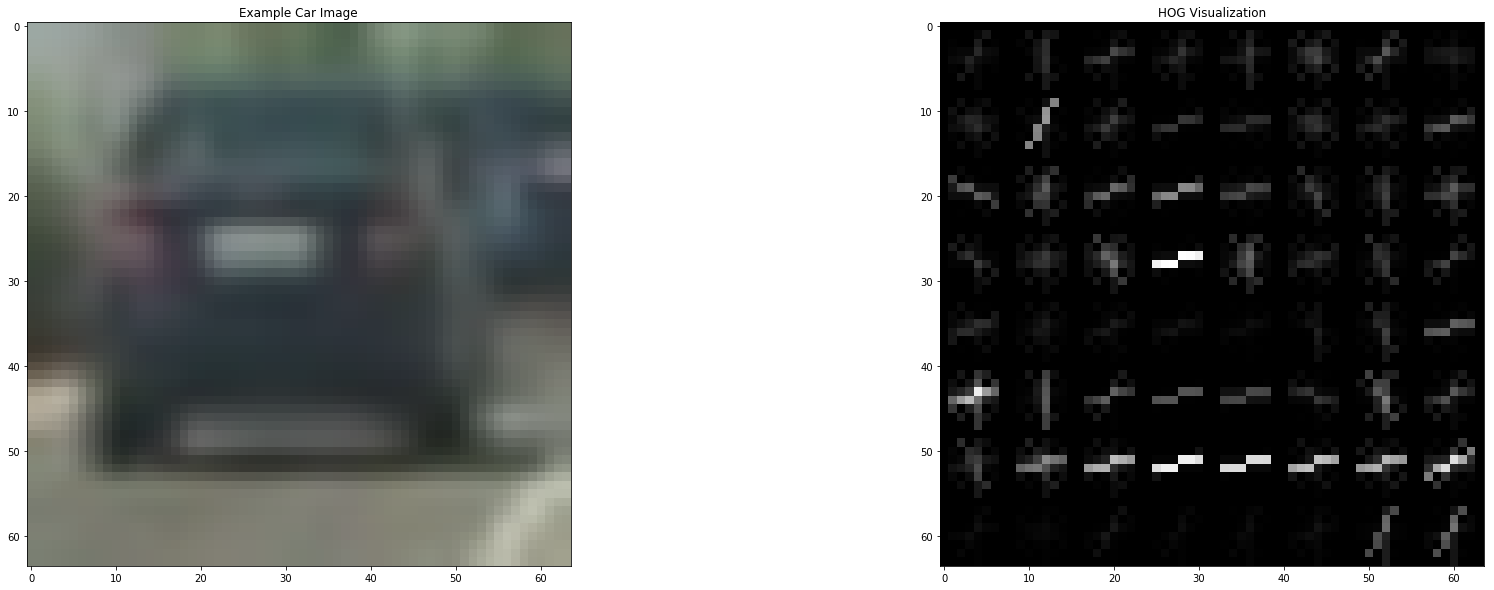

In [6]:
detector = Vehicle_Detector()
image = read_image('./vehicles/GTI_Far/image0000.png')

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
features, hog_image = detector.get_hog_features(gray, vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure(figsize=(30,10))
plt.subplot(121)
plt.imshow(image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

## Predicting an Image

The vehicle detector can be invoked to classify an image as either containing or not containing a car: 

In [ ]:
img = read_image('./non-vehicles/GTI/image1.png')

fig = plt.figure(figsize=(30,10))
plt.subplot(121)
plt.imshow(img)

result = detector.predict_image(img)
if result[0] == 1.0:
    answer = 'a car'
else:
    answer = 'no car'
print("My prediction: This image is: ", answer)

## Sliding window search

Invoking the clasifier:

In [ ]:
image = read_image('./test_images/test1.jpg')
#detector = Vehicle_Detector()
out_img = detector.find_cars(image, scale=2.5, plot=True)

import glob
test_images = glob.glob('./false-positives/*.png')
test_images.sort()
#detector = Vehicle_Detector()
answers = []
for index, filename in enumerate(test_images):
    img = read_image(filename)
    result = detector.predict_image(img)[0]
    if result == 1:
        print(filename)  

## The Processing Pipeline:

In [15]:
class ProcessImage:
    def __init__(self):

        OFFSET = 130
        SRC = np.float32([  (30, 703),
                            (540, 466),
                            (720, 466),
                            (1147, 703)])

        DST = np.float32([  (SRC[0][0] + OFFSET, 720),
                            (SRC[0][0] + OFFSET, 0),
                            (SRC[-1][0] - OFFSET, 0),
                            (SRC[-1][0] - OFFSET, 720)])
        
        self.transformer = PerspectiveTransform(SRC, DST)
        self.lane_detector = LaneDetector()
        self.vehicle_detector = Vehicle_Detector()
        self.frame_buffer_size = 10
        self.frame_buffer = []
        
    def process_lane_lines(self, img):
        
        undistorted = self.transformer.undistort(img)
        warped = self.transformer.warp(undistorted)
        binary = self.transformer.generate_binary(warped)
        self.lane_detector.process_frame(binary)

        warp_zero = np.zeros_like(binary).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        ploty, left_fitx, right_fitx = self.lane_detector.get_params()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = self.transformer.inverse_warp(color_warp) #cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
        # Combine the result with the original image
        
        print(undistorted.shape, newwarp.shape)
        result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
        
        deviation, radius = self.lane_detector.get_deviation_and_curvature()
        
        font = cv2.FONT_HERSHEY_TRIPLEX
        cv2.putText(result, 'Line Radius is %d (m)' % radius, (50, 50), font, 1, (255, 255, 255), 2)
        left_right = 'left' if deviation < 0 else 'right'
        cv2.putText(result, 'Vehicle is %.2f (m) %s of center' % (np.abs(deviation), left_right), (50, 100), font, 1, (255, 255, 255), 2)
        
        return result
     
    def add_heat(self, heatmap, bbox_list):
        # Iterate through list of bboxes
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

        # Return updated heatmap
        return heatmap  # Iterate through list of bboxes

    def reduce_heat(self, heatmap, bbox_list):
        # Iterate through list of bboxes
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] -= 1

        # Return updated heatmap
        return heatmap  # Iterate through list of bboxes

    def apply_threshold(self, heatmap, threshold):
        # Zero out pixels below the threshold
        heatmap[heatmap <= threshold] = 0
        # Return thresholded map
        return heatmap

    def draw_labeled_bboxes(self, img, labels):
        # Iterate through all detected cars
        for car_number in range(1, labels[1] + 1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 1), 6)
        # Return the image
        return img
    
    def remove_MD_FP(self, bboxes, plot=False):
        
        heat = np.zeros_like(image[:, :, 0]).astype(np.float)
        # Add heat to each box in box list
        heat = self.add_heat(heat, bboxes)

        # Apply threshold to help remove false positives
        heat = self.apply_threshold(heat, 1)

        # Visualize the heatmap when displaying
        heatmap = np.clip(heat, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)        
        print(labels[1], 'cars found')
        #plt.imshow(labels[0], cmap='gray')
        
        draw_img = self.draw_labeled_bboxes(np.copy(image), labels)

        if plot == True:
            fig = plt.figure(figsize=(30,10))
            plt.subplot(121)
            plt.imshow(draw_img)
            plt.title('Car Positions')
            plt.subplot(122)
            plt.imshow(heatmap, cmap='hot')
            plt.title('Heat Map')
            fig.tight_layout()
            
        return draw_img, heatmap
        
    def add_to_frame_buffer(self, heatmap, bboxes):
        self.frame_buffer.append((heatmap, bboxes))
        if len(self.frame_buffer) > self.frame_buffer_size:
            self.frame_buffer.pop(0)
            for heatmap, bboxes in self.frame_buffer:
                self.reduce_heat(heatmap, bboxes)
    
    def search_cars(self, image, plot=False):
        
        bboxes = self.vehicle_detector.find_cars(image, scale=2.5)
        
        image, heatmap = self.remove_MD_FP(bboxes, plot=plot)
        
        self.add_to_frame_buffer(heatmap, bboxes)
        
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        return image
    
    def process_image(self, image, plot=False):
        
        lanes = self.process_lane_lines(np.copy(image))
        #vehicles = self.search_cars(np.copy(image), plot=plot)
        
        result = lanes
        return result

# Running on an Image

Loading Classifier...
Classifier Loaded.
(720, 1280, 3) (720, 1280, 3)


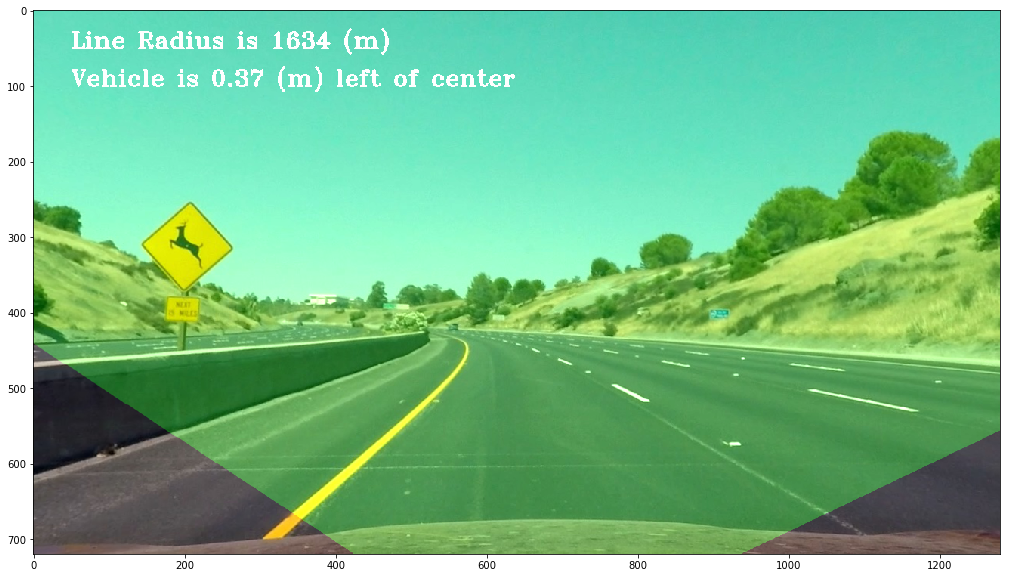

In [16]:
image = mpimg.imread('./test_images/test2.jpg')
processor = ProcessImage()
result = processor.process_image(image)
plt.figure(figsize=(20,10))
plt.imshow(result)

# Running on a Video

In [ ]:
video_processor = ProcessImage()
vid_output = 'test_video_out.mp4'
clip = VideoFileClip('test_video.mp4')
vid_clip = clip.fl_image(video_processor.process_image)
%time vid_clip.write_videofile(vid_output, audio=False)

In [ ]:
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('test_video_out.mp4'))